### EXP: Heat map all experts raters

In [251]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [334]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [335]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [336]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [337]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [338]:
ratings = classifications.loc[classifications['workflow_name'].isin(['Expert Project 1'])]

In [339]:
ratings.user_name.value_counts()

alinanaseer    153
ashherr17      118
angelatam      101
jenichen       100
ppf            100
abadhwar       100
Name: user_name, dtype: int64

In [340]:
# Filter out only specific workflows and users
ratings = classifications.loc[classifications['workflow_name'].isin(['Expert Project 1'])]
# Get 3 experts from previous workflow
rating_ = classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
rating1 = rating_[rating_.user_name.isin([ 'colezweber','jenichen'])]
ratings = ratings.append(rating1)
# Get other expert from other workflow
rating2 = classifications.loc[classifications['workflow_name'].isin(['Expert Project 2'])]
ratings = ratings.append(rating2)
ratings.count()

classification_id    1432
user_name            1432
user_id              1432
user_ip              1432
workflow_id          1432
workflow_name        1432
workflow_version     1432
created_at           1432
gold_standard           0
expert                  0
metadata             1432
annotations          1432
subject_data         1432
subject_ids          1432
dtype: int64

In [341]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]

In [342]:
ratings.user_name.unique()

array(['angelatam', 'jenichen', 'alinanaseer', 'ashherr17', 'ppf',
       'abadhwar', 'colezweber', 'surchs', 'crocodoyle', 'emdupre',
       'cmakowski', 'paulej', 'EloiPrevost', 'venguix'], dtype=object)

In [343]:
# Remove 1 non-experts('alinanaseer' because she rated twice the imges) raters and keep the other one 'ashherr17'
ratings = ratings[~ratings.user_name.isin(['crocodoyle',
                                           'alinanaseer',
                                           'EloiPrevost',
                                           'venguix',
                                           'ashherr17'])]

In [344]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

colezweber    149
jenichen      127
surchs        105
paulej        102
emdupre       102
cmakowski     102
angelatam     101
ppf           100
abadhwar      100
Name: user_name, dtype: int64

In [345]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

colezweber    149
jenichen      127
surchs        105
paulej        102
emdupre       102
cmakowski     102
angelatam     101
ppf           100
abadhwar      100
Name: user_name, dtype: int64

In [346]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    988
user_name            988
user_id              988
user_ip              988
workflow_id          988
workflow_name        988
workflow_version     988
created_at           988
gold_standard          0
expert                 0
metadata             988
annotations          988
subject_data         988
subject_ids          988
n_tagging            988
rating               988
ID                   988
imgnm                988
dtype: int64

In [347]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

angelatam have 1 duplicated ratings
jenichen have 27 duplicated ratings
colezweber have 49 duplicated ratings
surchs have 5 duplicated ratings
emdupre have 2 duplicated ratings
cmakowski have 2 duplicated ratings
paulej have 2 duplicated ratings
Total number of duplicated ratings  = 88


In [348]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

jenichen      100
paulej        100
emdupre       100
ppf           100
cmakowski     100
surchs        100
abadhwar      100
angelatam     100
colezweber    100
Name: user_name, dtype: int64

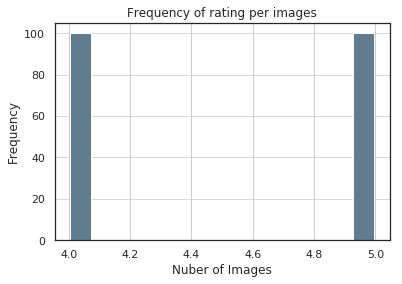

In [349]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [350]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,jenichen,paulej,emdupre,ppf,cmakowski,surchs,abadhwar,angelatam,colezweber
0,X0010051,Maybe,OK,Maybe,OK,OK,OK,OK,OK,OK
1,X2571197,OK,OK,OK,OK,OK,OK,OK,OK,OK
2,X2014113,OK,OK,Maybe,OK,OK,OK,OK,OK,Maybe
3,X0010120,Maybe,Maybe,OK,OK,Maybe,Maybe,OK,Maybe,Maybe
4,X0010009,OK,OK,Maybe,OK,Fail,OK,Maybe,Maybe,OK


In [351]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [352]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X0010051,0,2,7
1,X2571197,0,0,9
2,X2014113,0,2,7
3,X0010120,0,6,3
4,X0010009,1,3,5


In [353]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'EconVal'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'Econ'] = max_rate
# merge with zcon
zcon_df = pd.read_csv('../data/rating/full_launch_zooniverse_consensus.csv')
df_norm = df_norm.merge(zcon_df,on= 'ID')
df_norm.head()

,ID,Fail,Maybe,OK,EconVal,Econ,ZconVal,Zcon
0,X0010051,0,0.222222,0.777778,0.777778,OK,0.434783,Fail
1,X2571197,0,0,1,1.000000,OK,0.565217,OK
2,X2014113,0,0.222222,0.777778,0.777778,OK,0.720000,OK
3,X0010120,0,0.666667,0.333333,0.666667,Maybe,0.687500,OK
4,X0010009,0.111111,0.333333,0.555556,0.555556,OK,0.545455,OK


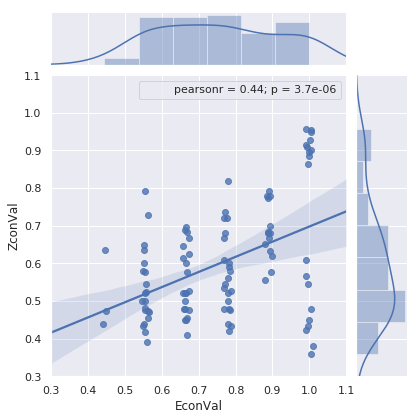

In [367]:
import scipy.stats as stats
sns.set(color_codes=True)
dd =df_norm.get(['OK','Maybe'])
aa = sns.jointplot(x='EconVal', y='ZconVal',data= df_norm,
                   kind="reg",xlim=[0.3,1.1], ylim=[0.3,1.1],x_jitter=.01)
aa.annotate(stats.pearsonr)

Text(0, 0.5, 'Concensus rating')

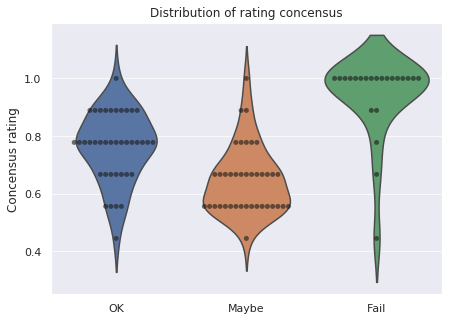

In [368]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='Econ',y='EconVal',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='Econ',y='EconVal',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

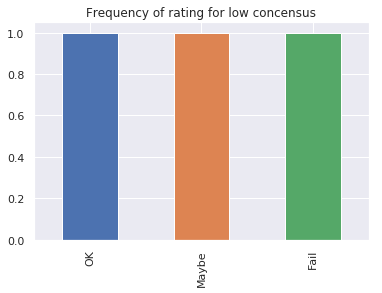

In [369]:
count_ = df_norm.Econ[[0 <= row.EconVal < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

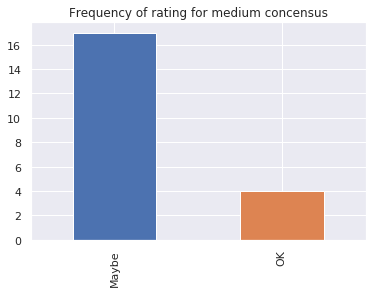

In [370]:
count_ = df_norm.Econ[[0.5 <= row.EconVal < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

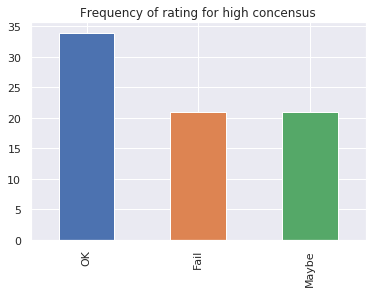

In [371]:
count_ = df_norm.Econ[[0.6 < row.EconVal <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [373]:
# Save a copy
df_ratings.rename(columns={'angelatam':'Atam',
                           'colezweber':'Czwe',
                           'ppf':'Pfer',
                           'jenichen':'Jche',
                           'abadhwar':'Abad',
                           'cmakowski':'Cmak',
                           'surchs':'Surc',
                           'paulej':'Jpau',
                           'emdupre':'Edup'},inplace=True)
df_ratings =df_ratings[['ID',
                        'Surc',
                        'Jpau',
                        'Cmak',
                        'Edup',
                        'Abad',
                        'Atam',
                        'Jche',
                        'Pfer', 'Czwe']].merge(df_norm[['ID','Econ','Zcon','EconVal','ZconVal']],on='ID')
df_ratings.to_csv('../data/rating/all_experts_ratings.csv',index=False)
df_ratings.head()

,ID,Surc,Jpau,Cmak,Edup,Abad,Atam,Jche,Pfer,Czwe,Econ,Zcon,EconVal,ZconVal
0,X0010051,OK,OK,OK,Maybe,OK,OK,Maybe,OK,OK,OK,Fail,0.777778,0.434783
1,X2571197,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,1.000000,0.565217
2,X2014113,OK,OK,OK,Maybe,OK,OK,OK,OK,Maybe,OK,OK,0.777778,0.720000
3,X0010120,Maybe,Maybe,Maybe,OK,OK,Maybe,Maybe,OK,Maybe,Maybe,OK,0.666667,0.687500
4,X0010009,OK,OK,Fail,Maybe,Maybe,Maybe,OK,OK,OK,OK,OK,0.555556,0.545455


In [374]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

df_ratings.head()

,ID,Surc,Jpau,Cmak,Edup,Abad,Atam,Jche,Pfer,Czwe,Econ,Zcon,EconVal,ZconVal
0,X0010051,1,1,1,2,1,1,2,1,1,1,3,0.777778,0.434783
1,X2571197,1,1,1,1,1,1,1,1,1,1,1,1.000000,0.565217
2,X2014113,1,1,1,2,1,1,1,1,2,1,1,0.777778,0.720000
3,X0010120,2,2,2,1,1,2,2,1,2,2,1,0.666667,0.687500
4,X0010009,1,1,3,2,2,2,1,1,1,1,1,0.555556,0.545455


In [375]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [376]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings.drop(['ID','EconVal','Econ','Zcon','ZconVal'],axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 9 
  %-agree = 19 



In [377]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [378]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [381]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings.drop(['ID','EconVal','ZconVal','Econ','Zcon'],axis=1)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.54 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 9 
    Kappa = 0.431 

        z = 36.2 
  p-value = 0 



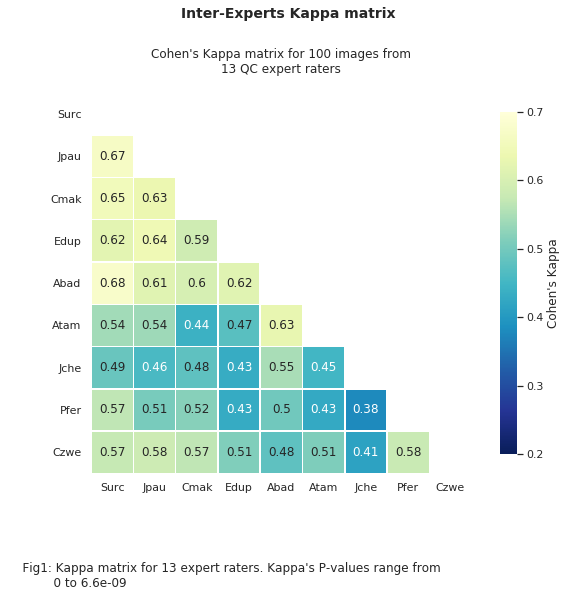

In [390]:
# Plot kappa matrix for expert only
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Inter-Experts Kappa matrix',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
mask = np.zeros_like(kappa_out)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(kappa_out,vmin=0.2,vmax=0.7,cmap="YlGnBu_r",
            square=True,
            annot=True,
            mask = mask,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
sns.set(style="white")
sns.axes_style("white")

axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
text_title = '''
Cohen's Kappa matrix for {} images from
{} QC expert raters'''.format(len(df_ratings),len(df_ratings.columns[1:]))
axes.set_title(text_title,pad=20,fontsize=12)
#axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              #arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            #fc="0.7", ec="none",
                            #linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for {} expert raters. Kappa's P-values range from
            {:.2g} to {:.2g} '''.format(len(df_ratings.columns[1:]),Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12);
#f.text(0.11,0.88,'High',fontsize=12)
#f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Full-Launch-experts_qc.svg')

In [85]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Full lanch 1 raters

In [298]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X8628223,Expert Project 1,angelatam,Maybe,471.46875,599.0,1.5,1,X_8628223_anat.png,0
1,X0010088,Expert Project 1,angelatam,OK,NaN,NaN,NaN,0,X_0010088_anat.png,1
2,X0021015,Expert Project 1,angelatam,Maybe,47.46875,662.0,1.5,1,X_0021015_anat.png,0
3,X3011311,Expert Project 1,angelatam,OK,NaN,NaN,NaN,0,X_3011311_anat.png,1
4,X3433846,Expert Project 1,angelatam,Maybe,44.46875,659.0,1.5,2,X_3433846_anat.png,0


In [299]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm = df_ids_imgnm.merge(df_norm[['ID','EconVal','Econ']], on='ID')
df_ids_imgnm.head()

,ID,imgnm,EconVal,Econ
0,HC0040038,HC0040038_anat.png,0.555556,OK
1,HC0040043,HC0040043_anat.png,0.777778,OK
2,HC0040045,HC0040045_anat.png,0.777778,OK
3,HC0040048,HC0040048_anat.png,0.555556,Maybe
4,HC0040050,HC0040050_anat.png,0.666667,OK


In [300]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [301]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

In [302]:
# Populate patches
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row_.x,row_.y,row.EconVal,row.Econ) for ind,row_ in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']
patches_df = pd.DataFrame(patches, columns=['x','y','cons','rate'])
patches_df.head()

,x,y,cons,rate
0,113.200073,301.0,0.555556,OK
1,79.160622,599.0,0.555556,OK
2,87.633331,192.0,0.555556,OK
3,86.468750,600.0,0.555556,OK
4,316.468750,302.0,0.555556,OK


### Plot heat map for all tagging

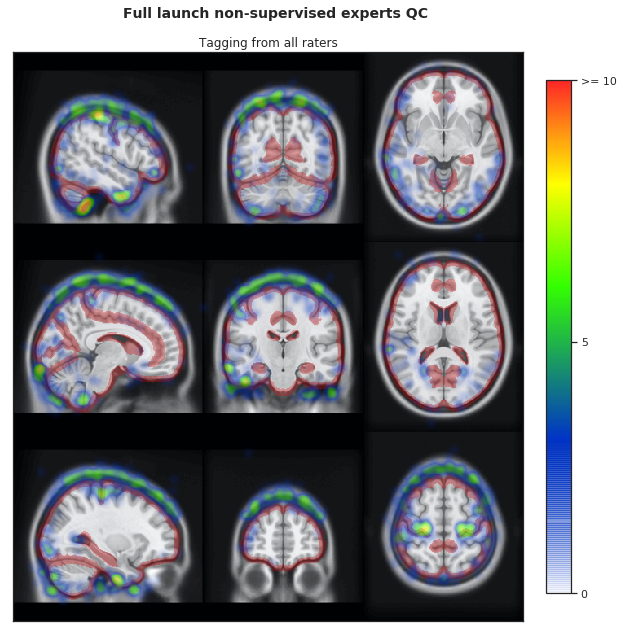

In [303]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch non-supervised experts QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=20,
                        point_strength = 0.1,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
#f.savefig('../reports/figures/Full_launch1_non-supervised-experts-heatmap_tags.svg')

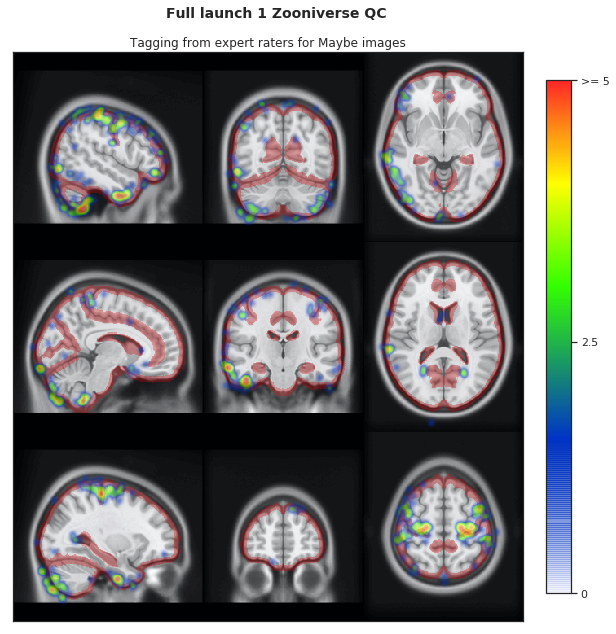

In [304]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from expert raters for Maybe images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Maybe' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.3,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_expert_heatmap_Maybe_tags.svg')


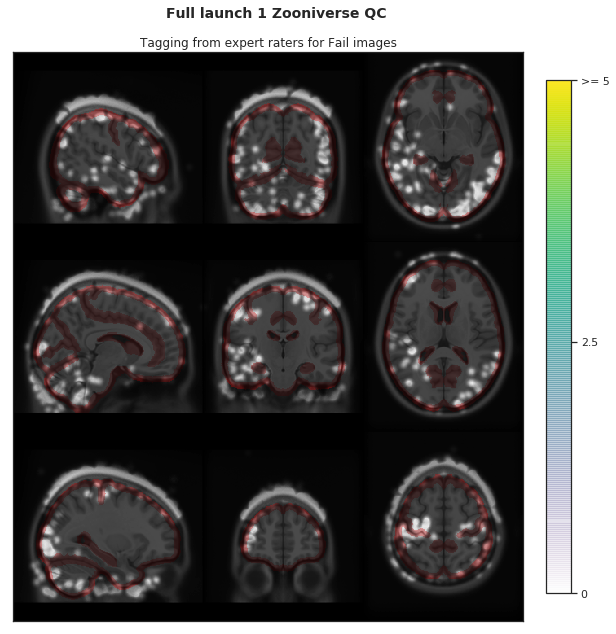

In [305]:
from heatmappy import Heatmapper
from PIL import Image

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .7)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from expert raters for Fail images')

#select specific patches
patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == 'Fail' and rr.cons >= 0 ]
heatmapper = Heatmapper(opacity=0.75,
                        point_diameter=15,
                        point_strength = 0.3,
                        colours='reveal')
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=my_cmap)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '2.5', '>= 5'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Full_launch1_expert_heatmap_Fail_tags.svg')


In [145]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
# Random data
data1 = np.random.random((4,4))

# Choose colormap
cmap = plt.cm.viridis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [143]:
cmap = plt.cm.viridis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

In [144]:
aa= LinearSegmentedColormap.from_list('from_image', my_cmap)

In [139]:
my_cmap

array([[0.993248  , 0.906157  , 0.143936  , 0.        ],
       [0.983868  , 0.904867  , 0.136897  , 0.00392157],
       [0.974417  , 0.90359   , 0.130215  , 0.00784314],
       ...,
       [0.269944  , 0.014625  , 0.341379  , 0.99215686],
       [0.26851   , 0.009605  , 0.335427  , 0.99607843],
       [0.267004  , 0.004874  , 0.329415  , 1.        ]])